In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import brewer2mpl
from mitgcmdata import MITgcmmodel
from jmd95 import eos
import datetime
import sose_maps
reload(sose_maps)

%matplotlib inline
plt.rcParams['image.origin'] = 'bottom'
plt.rcParams['figure.figsize'] = (16,8)


bmap = brewer2mpl.get_map('Set1', 'Qualitative', 6)
plt.rcParams['axes.color_cycle'] = bmap.mpl_colors


In [10]:
ddir = '/data/scratch/rpa/SOSE/run_matt'
m = MITgcmmodel.ModelInstance(output_dir=ddir)
lon = m.xc[0,:,:]
lat = m.yc[0,:,:]

2160 320  42


In [22]:
fw_flux_types = ['IO_plus_AO', 'AI_plus_AO', 'AI', 'AO', 'IO', 'IO_brine', 'IO_melt']
#wmass_names = {'SAMW': 26.0, 'AAIW': 27.0, 'UCDW': 27.55, 'LCDW': 27.72, 'AABW': 27.82}

wmass_names = {'27.0': (26.95,27.05), '27.2': (27.15,27.25), '27.6': (27.55,27.65)}


In [4]:
rholevs = np.load('tmp_data/rholevs.npy')
rho = 0.5*(rholevs[1:] + rholevs[:-1])-1000
drho = np.diff(rholevs)

In [5]:
# forgot to normalize output by time
tr_map = np.load('tmp_data/tr_map.npy') / drho[np.newaxis,:,np.newaxis,np.newaxis] / 438 
trmix_map = np.load('tmp_data/trmix_map.npy') / drho[:,np.newaxis,np.newaxis]

In [26]:
tr = {}
trmix = {}

for name, rholims in wmass_names.iteritems():
    idx = (rho >= rholims[0]) & (rho < rholims[1])
    tr[name] = tr_map[:,idx].mean(axis=1)
    trmix[name] = trmix_map[idx].mean(axis=0)

In [6]:
                                           
idx_aaiw = (rho >= 27.15) & (rho < 27.25) # 27.2
idx_ucdw = (rho >= 27.55) & (rho < 27.65) # 27.6
drho_ucdw = drho[idx_ucdw].sum() 
drho_aaiw = drho[idx_ucdw].sum()
tr_ucdw = tr_map[:,idx_ucdw].mean(axis=1) 
tr_aaiw = tr_map[:,idx_aaiw].mean(axis=1)
trmix_ucdw = trmix_map[idx_ucdw].mean(axis=0)
trmix_aaiw = trmix_map[idx_aaiw].mean(axis=0)

In [7]:
tr_net = (tr_map * m.rac).sum(axis=-1).sum(axis=-1) 
mix_net = (trmix_map * m.rac).sum(axis=-1).sum(axis=-1) 

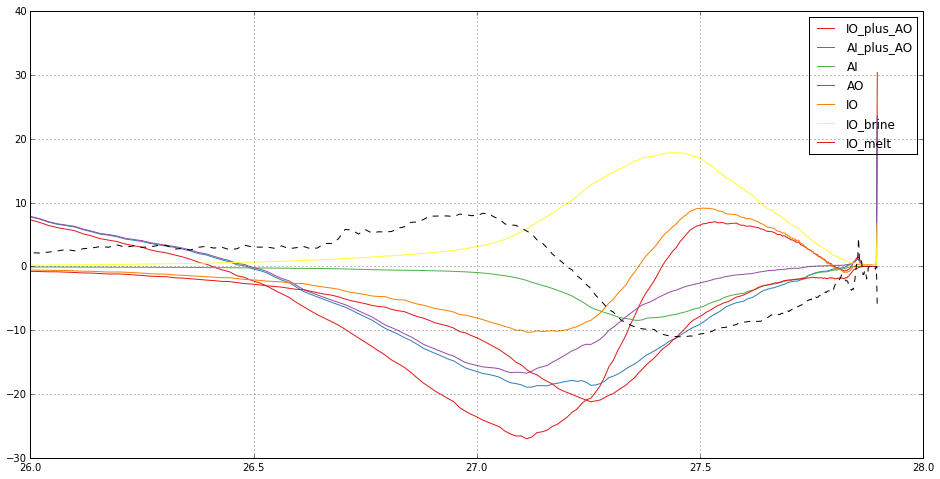

In [8]:
plt.plot(rho, tr_net.T / 1e6)
plt.plot(rho, mix_net / 1e6, 'k--')
plt.legend(fw_flux_types)
plt.xlim([26,28])
plt.grid()

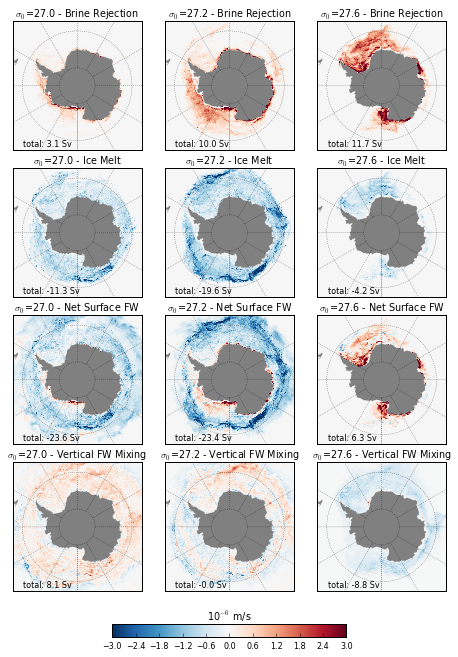

In [35]:
trlims = np.array([-3e-6, 3e-6])

plt.rcParams['font.size'] = 8
plt.rcParams['legend.fontsize'] = 8

plt.figure(figsize=(6.5,9))
plt.subplots_adjust(left=0.02, right=0.98, top=0.98, bottom=0.1,
                    hspace=0.14, wspace=0.05)

fldfac = 1e6

for i, wmname in enumerate(['27.0', '27.2', '27.6']):
    wmtr = tr[wmname]
    wmtrmix = trmix[wmname]
    for n, (fld,name) in enumerate(zip(
                (wmtr[-2], wmtr[-1], wmtr[0], wmtrmix),
                ('Brine Rejection', 'Ice Melt', 'Net Surface FW', 'Vertical FW Mixing'))):
    
        ax=plt.subplot(4,3,(3*n)+i+1)
        pc, bm = sose_maps.pcolormesh(lon, lat, fldfac*fld, labels=[0,0,0,0], 
                                      cmap='RdBu_r', rasterized=True)
        plt.clim(fldfac*trlims)
        x,y  = bm(-138,-47)
        ax.text(x,y,'total: %3.1f Sv' % ((fld*m.rac).sum()/1e6))
        plt.title(r'$\sigma_0$=%s - %s' % (wmname, name))
        
cbax = plt.axes((0.25,0.03,0.5,0.02))
cb = plt.colorbar(cax=cbax, orientation='horizontal')
#cb.formatter.set_powerlimits((0, 0))
cb.update_ticks()
cbax.set_title(r'10$^{-6}$ m/s')

plt.savefig('../figures_ice_moc/transformation_maps.pdf')

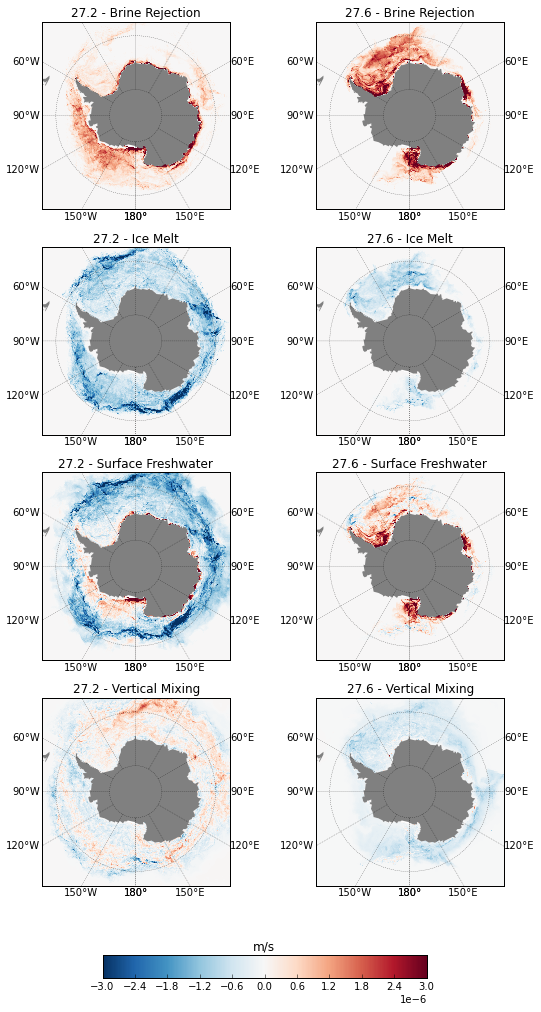

In [21]:
        
        
    plt.subplot(4,2,n+1)
    sose_maps.pcolormesh(lon, lat, tru, cmap='RdBu_r', rasterized=True)
    plt.title('27.6 - %s' % name)
    plt.clim(trlims)

plt.subplot(423)
sose_maps.pcolormesh(lon, lat, tr_aaiw[-1], cmap='RdBu_r', rasterized=True)
plt.clim(trlims)
plt.title('27.2 - Ice Melt')

plt.subplot(424)
sose_maps.pcolormesh(lon, lat, tr_ucdw[-1], cmap='RdBu_r', rasterized=True)
plt.title('27.6 - Ice Melt')
plt.clim(trlims)

plt.subplot(425)
sose_maps.pcolormesh(lon, lat, tr_aaiw[0], cmap='RdBu_r', rasterized=True)
plt.clim(trlims)
plt.title('27.2 - Surface Freshwater')

plt.subplot(426)
pc, _ = sose_maps.pcolormesh(lon, lat, tr_ucdw[0], cmap='RdBu_r', rasterized=True)
plt.title('27.6 - Surface Freshwater')
plt.clim(trlims)

plt.subplot(427)
sose_maps.pcolormesh(lon, lat, trmix_aaiw, cmap='RdBu_r', rasterized=True)
plt.clim(trlims)
plt.title('27.2 - Vertical Mixing')

plt.subplot(428)
pc, _ = sose_maps.pcolormesh(lon, lat, trmix_ucdw, cmap='RdBu_r', rasterized=True)
plt.title('27.6 - Vertical Mixing')
plt.clim(trlims)

cbax = plt.axes((0.25,0.07,0.5,0.02))
cb = plt.colorbar(cax=cbax, orientation='horizontal')
cb.formatter.set_powerlimits((0, 0))
cb.update_ticks()
cbax.set_title('m/s')

plt.savefig('../figures_ice_moc/transformation_maps.pdf')

In [ ]:
plt.text(